In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from pathlib2 import Path
from PIL import Image
import time

In [2]:
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [3]:
# Root directory for dataset
dataroot = Path('data/h5')

# Number of workers for dataloader
# Issues with python for windows when workers>0
workers = 0

# Batch size during training
batch_size = 32

# Spatial size of training images. 
hr_image_size = 256
lr_image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
# 64 by 64
nz = 4096

# Size of feature maps in generator
# starting smaller to make sure network fits
ngf = 32

# Size of feature maps in discriminator
# starting smaller to make sure network fits
ndf = 32

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.00005

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

imgextension = '.png'

In [4]:
# define custom dataset for both LR and HR images
# could potentially replace with one set of images and two sets of transforms?
# would this slow things down too much?

class SatDataset():
    def __init__(self, directories, lr_transform=transforms.ToTensor(), hr_transform=transforms.ToTensor()):
        lr_images = []
        hr_images = []
        #Get LR file names
        for dirName, _, fileList in os.walk(directories / 'lr_images'):
            for filename in fileList:
                if filename.endswith(imgextension):
                    lr_images.append(dirName + '/' + filename)
        #Get HR file names
        for idx, (dirName, _, fileList) in enumerate(os.walk(directories / 'hr_images')):
            for filename in fileList:
                if filename.endswith(imgextension):
                    hr_images.append(dirName + '/' + filename)
        
        #define self attributes
        self.lr_images = lr_images
        self.hr_images = hr_images
        self.directories = directories
        self.lr_transform = lr_transform
        self.hr_transform = hr_transform

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        
        #return image pair
        lr_image = Image.open(self.lr_images[idx])
        hr_image = Image.open(self.hr_images[idx])

        #after transformation
        lr_image = self.lr_transform(lr_image)
        hr_image = self.hr_transform(hr_image)
        return [lr_image, hr_image]

In [5]:
# define transforms
lr_transform = transforms.Compose([transforms.Resize(lr_image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

hr_transform = transforms.Compose([transforms.Resize(hr_image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#initialise dataset
satdataset = SatDataset(
                     os.getcwd()/dataroot, 
                     lr_transform = lr_transform, hr_transform = hr_transform
                    )

#initialise dataloader 
dataloader = torch.utils.data.DataLoader(
    satdataset, 
    batch_size=batch_size, shuffle=True,
    num_workers=workers, pin_memory=False
)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
#device = torch.device("cpu")

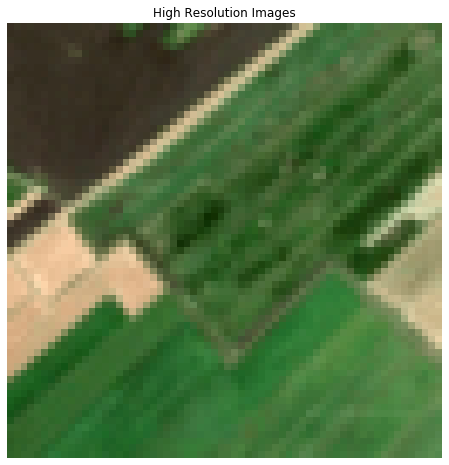

In [6]:
##Plot some training images
# need to fix to suit new dataloader and size
if __name__ == '__main__': #this line makes this work in windows
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.title("High Resolution Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0:1][0].to(device)[0], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
test = netG(real_batch[0])
test.shape

NameError: name 'netG' is not defined

In [8]:
#plt.imshow(np.transpose(real_batch[1][0]))

In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [10]:
#implement a residual block
#need to research how to implement the big overall skip connection - check how forward works for G net
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1  = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1, bias=False)
        self.bnorm1 = nn.BatchNorm2d(nf)
        self.relu1  = nn.ReLU(True)
            
        self.conv2  = nn.Conv2d(nf, nf, kernel_size=3, stride=1, padding=1, bias=False)
        self.bnorm2 = nn.BatchNorm2d(nf)
        self.relu2  = nn.ReLU(True)
            
            
    def forward(self, x): return x + self.relu2(self.bnorm2(self.conv2(self.relu1(self.bnorm1(self.conv1(x))))))

In [11]:
# Homecooked Upsampling Network 
# consider how to plug the upsampled image back - potentially a few sections of networks for each upsampling stage?
# try using this raw first and check results
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )       
#         self.main = nn.Sequential(
#             #64*64*3
#             nn.Conv2d(3, 16, kernel_size=4, stride=2, padding=1, bias=False),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             #32*32*16
#             nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             #32*32*32
#             ResBlock(32),
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             ResBlock(64),
#             #32*32*64
#             nn.ConvTranspose2d(64, 192, kernel_size=3, stride=1, padding=1, bias=False),
#             nn.BatchNorm2d(192),
#             nn.ReLU(192),
#             ResBlock(192),
#             #32*32*196
#             nn.Conv2d(192, 192, 3, 1, 1),
#             nn.PixelShuffle(2),
#             nn.ReLU(),
#             ResBlock(48),
#             #64*64*48
#             nn.Conv2d(48, 48, 3, 1, 1),
#             nn.PixelShuffle(2),
#             nn.ReLU(),
#             ResBlock(12),
#             #128x128x12
#             nn.Conv2d(12, 12, 3, 1, 1),
#             nn.PixelShuffle(2),
#             nn.ReLU(),
#             #256*256*3
#             nn.Conv2d(3, 3, kernel_size=9, stride=1, padding=4),
#             nn.Tanh()
#             #256x256x3
#         )
    def forward(self, input):
        return self.main(input)

In [12]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): ResBlock(
      (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(64, e

In [16]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 256 x 256
            nn.Conv2d(nc, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # input is (nc) x 128 x 128
            nn.Conv2d(ndf, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            
            # input is (nc) x 64 x 64
            nn.Conv2d(ndf, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [22]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=

In [29]:
# Initialize BCELoss function
#criterion = nn.BCELoss()
l2loss    = nn.MSELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
#fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [36]:
# Training Loop Just for Generator

# Lists to keep track of progress
img_list = []
G_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
if __name__ == '__main__':
    for epoch in range(10):
        # For each batch in the dataloader
        for i, (l_res, h_res) in enumerate(dataloader, 0):
            
            l_res_cuda = l_res.to(device)
            h_res_cuda = h_res.to(device)
            ############################
            #Update G network: 
            ###########################
            netG.zero_grad()
            #label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netG(l_res_cuda)
            # Calculate G's loss based on this output
            errG = l2loss(output, h_res_cuda)
            # Calculate gradients for G
            errG.backward()
            D_G = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_G: %.4f\tD(G(z)): %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                            errG.item(), D_G))

            # Save Losses for plotting later
            G_losses.append(errG.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(l_res_cuda).detach().cpu()
                    real = h_res_cuda.detach().cpu()
                img_list.append(vutils.make_grid(fake, nrow=4, padding=2, normalize=True))
                img_list.append(vutils.make_grid(real, nrow=4, padding=2, normalize=True))

            iters += 1

Starting Training Loop...
[0/5][0/13]	Loss_G: 0.1854	D(G(z)): -0.0059
[1/5][0/13]	Loss_G: 0.1718	D(G(z)): -0.0062
[2/5][0/13]	Loss_G: 0.1624	D(G(z)): -0.0063
[3/5][0/13]	Loss_G: 0.1721	D(G(z)): -0.0061
[4/5][0/13]	Loss_G: 0.1783	D(G(z)): -0.0060
[5/5][0/13]	Loss_G: 0.1783	D(G(z)): -0.0060
[6/5][0/13]	Loss_G: 0.1852	D(G(z)): -0.0064
[7/5][0/13]	Loss_G: 0.1648	D(G(z)): -0.0066
[8/5][0/13]	Loss_G: 0.1855	D(G(z)): -0.0065
[9/5][0/13]	Loss_G: 0.1856	D(G(z)): -0.0062


In [30]:
fake.shape

torch.Size([16, 3, 256, 256])

In [ ]:
# # Training Loop

# # Lists to keep track of progress
# img_list = []
# G_losses = []
# D_losses = []
# iters = 0

# print("Starting Training Loop...")
# # For each epoch
# if __name__ == '__main__':
#     for epoch in range(num_epochs):
#         # For each batch in the dataloader
#         for i, (l_res, h_res) in enumerate(dataloader, 0):
            
#             h_res = h_res.unsqueeze(0)

#             ############################
#             # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
#             ###########################
#             ## Train with all-real batch
#             netD.zero_grad()
#             # Format batch
#             real_cpu = h_res[0].to(device)
#             b_size = real_cpu.size(0)
#             label = torch.full((b_size,), real_label, device=device)
#             # Forward pass real batch through D
#             output = netD(real_cpu).view(-1)
#             # Calculate loss on all-real batch
#             errD_real = criterion(output, label)
#             # Calculate gradients for D in backward pass
#             errD_real.backward()
#             D_x = output.mean().item()


#             ## This is where we could put the lowres images???
#             ## Train with all-fake batch

#             # Generate batch of latent vectors
#             # noise = torch.randn(b_size, nz, 1, 1, device=device)
#             # Generate fake image batch with G
#             l_res_cuda = l_res.to(device)
#             fake = netG(l_res_cuda)
#             label.fill_(fake_label)

#             # Classify all fake batch with D
#             output = netD(fake.detach()).view(-1)
#             # Calculate D's loss on the all-fake batch
#             errD_fake = criterion(output, label)
#             # Calculate the gradients for this batch
#             errD_fake.backward()
#             D_G_z1 = output.mean().item()
#             # Add the gradients from the all-real and all-fake batches
#             errD = errD_real + errD_fake
#             # Update D
#             optimizerD.step()

#             ############################
#             # (2) Update G network: maximize log(D(G(z)))
#             ###########################
#             netG.zero_grad()
#             label.fill_(real_label)  # fake labels are real for generator cost
#             # Since we just updated D, perform another forward pass of all-fake batch through D
#             output = netD(fake).view(-1)
#             # Calculate G's loss based on this output
#             errG = criterion(output, label)
#             # Calculate gradients for G
#             errG.backward()
#             D_G_z2 = output.mean().item()
#             # Update G
#             optimizerG.step()

#             # Output training stats
#             if i % 50 == 0:
#                 print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
#                       % (epoch, num_epochs, i, len(dataloader),
#                          errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

#             # Save Losses for plotting later
#             G_losses.append(errG.item())
#             D_losses.append(errD.item())

#             # Check how the generator is doing by saving G's output on fixed_noise
#             if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
#                 with torch.no_grad():
#                     fake = netG(l_res_cuda).detach().cpu()
#                 img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

#             iters += 1

In [29]:
img_list[-1].shape



torch.Size([3, 518, 2066])

In [ ]:
netG(l_res_cuda)[0]

NameError: name 'D_losses' is not defined

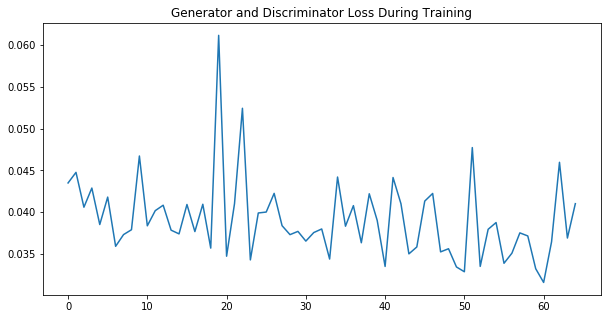

In [23]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

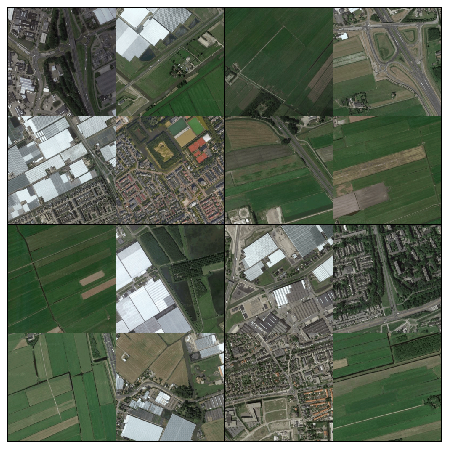

In [24]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

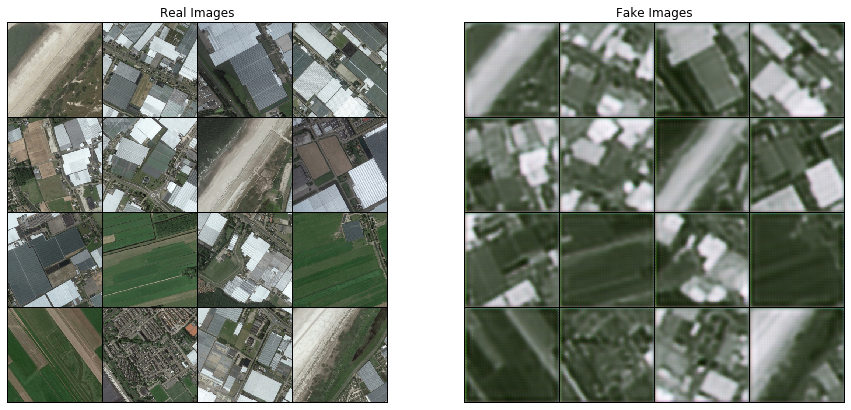

In [33]:
# Grab a batch of real images from the dataloader
(plc, real_batch) = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
#plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:16], nrow=4, padding=5, normalize=True).cpu(),(1,2,0)))
plt.imshow(np.transpose(img_list[-1],(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-2],(1,2,0)))
plt.show()

In [75]:
torch.cuda.empty_cache()

In [76]:
plt.imshow(netG(real_batch.to(device))[0])

RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 4.00 GiB total capacity; 2.95 GiB already allocated; 4.97 MiB free; 2.96 GiB reserved in total by PyTorch)